<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 15:21:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   34C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.5950734819998615
GPU (s):
0.030575346998375608
GPU speedup over CPU: 19x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.vgg19.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
80150528/80134624 [==============================] - 63s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 21s 49ms/step - loss: 1.7960 - accuracy: 0.5716 - val_loss: 0.7619 - val_accuracy: 0.6749
Epoch 2/100
360/360 [==============================] - 18s 49ms/step - loss: 0.8195 - accuracy: 0.6573 - val_loss: 0.7399 - val_accuracy: 0.6803
Epoch 3/100
360/360 [==============================] - 16s 45ms/step - loss: 0.7519 - accuracy: 0.6831 - val_loss: 0.6851 - val_accuracy: 0.7093
Epoch 4/100
360/360 [==============================] - 16s 44ms/step - loss: 0.7163 - accuracy: 0.6957 - val_loss: 0.6626 - val_accuracy: 0.7200
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 0.6961 - accuracy: 0.7065 - val_loss: 0.6597 - val_accuracy: 0.7240
Epoch 6/100
360/360 [===================

360/360 [==============================] - 16s 43ms/step - loss: 0.5287 - accuracy: 0.7877 - val_loss: 0.5555 - val_accuracy: 0.7803
Epoch 55/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5224 - accuracy: 0.7876 - val_loss: 0.5568 - val_accuracy: 0.7760
Epoch 56/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5239 - accuracy: 0.7864 - val_loss: 0.5651 - val_accuracy: 0.7758
Epoch 57/100
360/360 [==============================] - 16s 43ms/step - loss: 0.5205 - accuracy: 0.7883 - val_loss: 0.5506 - val_accuracy: 0.7793
Epoch 58/100
360/360 [==============================] - 18s 50ms/step - loss: 0.5210 - accuracy: 0.7909 - val_loss: 0.5650 - val_accuracy: 0.7681
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5178 - accuracy: 0.7911 - val_loss: 0.5513 - val_accuracy: 0.7798
Epoch 60/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5256 - accuracy: 0.7858 - val_loss: 0.5572 - val_accuracy

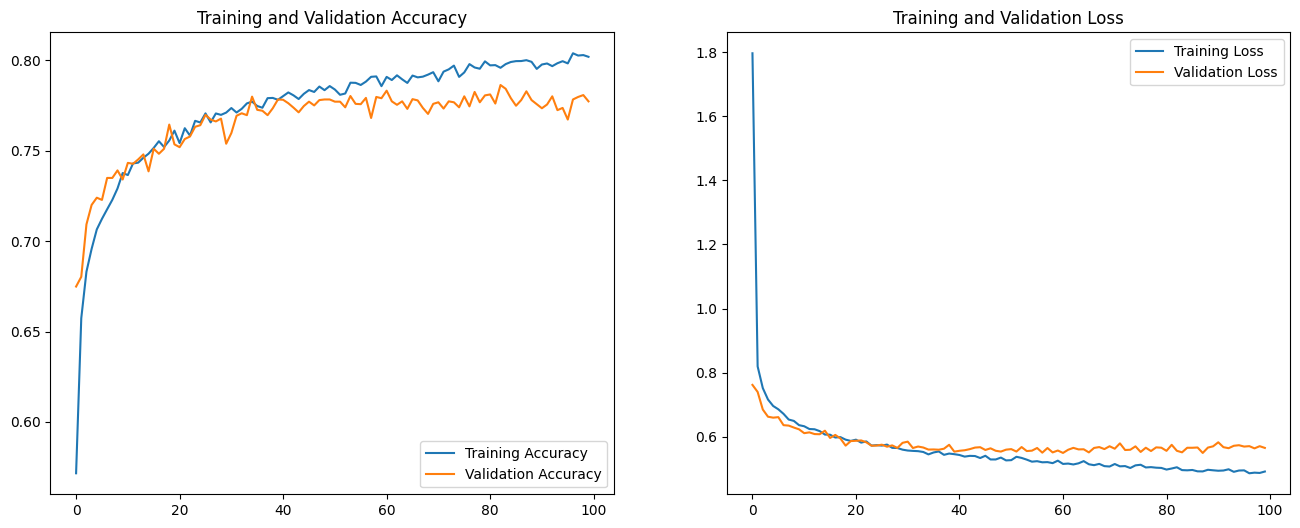

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 18s 43ms/step - loss: 1.7109 - accuracy: 0.5585 - val_loss: 0.7869 - val_accuracy: 0.6683
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 0.8507 - accuracy: 0.6403 - val_loss: 0.7344 - val_accuracy: 0.6791
Epoch 3/100
360/360 [==============================] - 15s 42ms/step - loss: 0.7802 - accuracy: 0.6682 - val_loss: 0.7047 - val_accuracy: 0.6973
Epoch 4/100
360/360 [==============================] - 15s 43ms/step - loss: 0.7522 - accuracy: 0.6821 - val_loss: 0.6983 - val_accuracy: 0.6962
Epoch 5/100
360/360 [==============================] - 16s 43ms/step - loss: 0.7246 - accuracy: 0.6885 - val_loss: 0.6996 - val_accuracy: 0.6975
Epoch 6/100
360/360 [==============================] - 16s 44ms/step - loss: 0.7187 - accuracy: 0.6920 - val_loss: 0.6832 - va

360/360 [==============================] - 16s 44ms/step - loss: 0.5727 - accuracy: 0.7640 - val_loss: 0.6046 - val_accuracy: 0.7504
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5703 - accuracy: 0.7623 - val_loss: 0.6125 - val_accuracy: 0.7492
Epoch 58/100
360/360 [==============================] - 15s 42ms/step - loss: 0.5726 - accuracy: 0.7621 - val_loss: 0.6253 - val_accuracy: 0.7480
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5624 - accuracy: 0.7688 - val_loss: 0.6040 - val_accuracy: 0.7510
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5713 - accuracy: 0.7600 - val_loss: 0.6078 - val_accuracy: 0.7504
Epoch 61/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5673 - accuracy: 0.7651 - val_loss: 0.6006 - val_accuracy: 0.7558
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5642 - accuracy: 0.7631 - val_loss: 0.6165 - val_accuracy

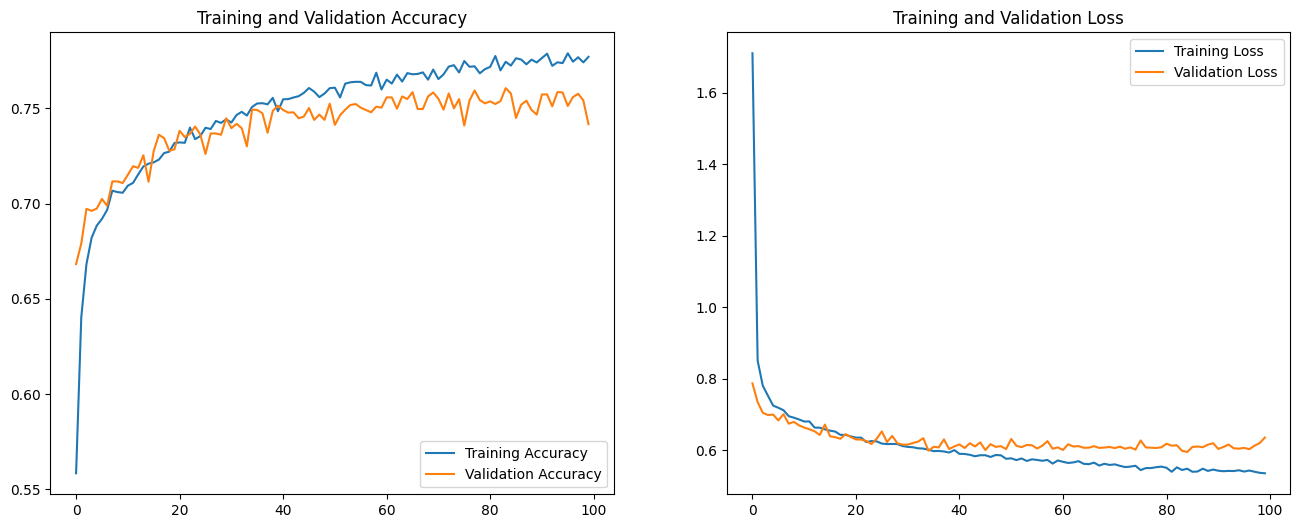

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.1020 - accuracy: 0.6616 - val_loss: 0.5717 - val_accuracy: 0.7567
Epoch 2/100
360/360 [==============================] - 16s 43ms/step - loss: 0.6392 - accuracy: 0.7308 - val_loss: 0.5371 - val_accuracy: 0.7675
Epoch 3/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5994 - accuracy: 0.7460 - val_loss: 0.5393 - val_accuracy: 0.7647
Epoch 4/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5685 - accuracy: 0.7572 - val_loss: 0.5018 - val_accuracy: 0.7879
Epoch 5/100
360/360 [==============================] - 16s 44ms/step - loss: 0.5593 - accuracy: 0.7597 - val_loss: 0.5001 - val_accuracy: 0.7794
Epoch 6/100
360/360 [==============================] - 16s 45ms/step - loss: 0.5386 - accuracy: 0.7720 - v

360/360 [==============================] - 16s 44ms/step - loss: 0.4178 - accuracy: 0.8278 - val_loss: 0.4007 - val_accuracy: 0.8326
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4108 - accuracy: 0.8315 - val_loss: 0.3944 - val_accuracy: 0.8380
Epoch 58/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4144 - accuracy: 0.8300 - val_loss: 0.4138 - val_accuracy: 0.8334
Epoch 59/100
360/360 [==============================] - 16s 45ms/step - loss: 0.4136 - accuracy: 0.8299 - val_loss: 0.4044 - val_accuracy: 0.8336
Epoch 60/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4128 - accuracy: 0.8295 - val_loss: 0.3909 - val_accuracy: 0.8394
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4128 - accuracy: 0.8311 - val_loss: 0.3925 - val_accuracy: 0.8380
Epoch 62/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4204 - accuracy: 0.8299 - val_loss: 0.4067 - val_accuracy

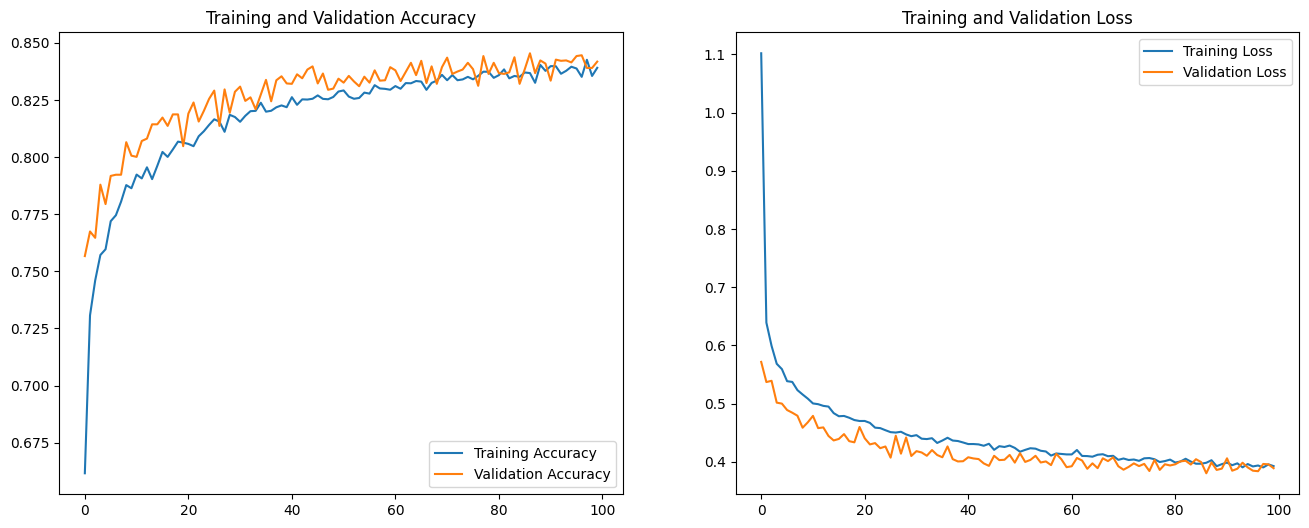

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.0551 - accuracy: 0.6602 - val_loss: 0.5706 - val_accuracy: 0.7633
Epoch 2/100
360/360 [==============================] - 15s 42ms/step - loss: 0.6579 - accuracy: 0.7243 - val_loss: 0.5412 - val_accuracy: 0.7756
Epoch 3/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5999 - accuracy: 0.7429 - val_loss: 0.5146 - val_accuracy: 0.7841
Epoch 4/100
360/360 [==============================] - 16s 43ms/step - loss: 0.5709 - accuracy: 0.7588 - val_loss: 0.5043 - val_accuracy: 0.7930
Epoch 5/100
360/360 [==============================] - 16s 43ms/step - loss: 0.5568 - accuracy: 0.7656 - val_loss: 0.4981 - val_accuracy: 0.7883
Epoch 6/100
360/360 [==============================] - 15s 42ms/step - loss: 0.5413 - accuracy: 0.7713 - val_loss: 0.4785 - va

360/360 [==============================] - 15s 43ms/step - loss: 0.4310 - accuracy: 0.8265 - val_loss: 0.3999 - val_accuracy: 0.8343
Epoch 57/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4311 - accuracy: 0.8237 - val_loss: 0.4002 - val_accuracy: 0.8392
Epoch 58/100
360/360 [==============================] - 16s 43ms/step - loss: 0.4296 - accuracy: 0.8229 - val_loss: 0.3991 - val_accuracy: 0.8425
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4278 - accuracy: 0.8273 - val_loss: 0.3922 - val_accuracy: 0.8406
Epoch 60/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4243 - accuracy: 0.8273 - val_loss: 0.4002 - val_accuracy: 0.8331
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4279 - accuracy: 0.8269 - val_loss: 0.3913 - val_accuracy: 0.8425
Epoch 62/100
360/360 [==============================] - 16s 43ms/step - loss: 0.4236 - accuracy: 0.8254 - val_loss: 0.3984 - val_accuracy

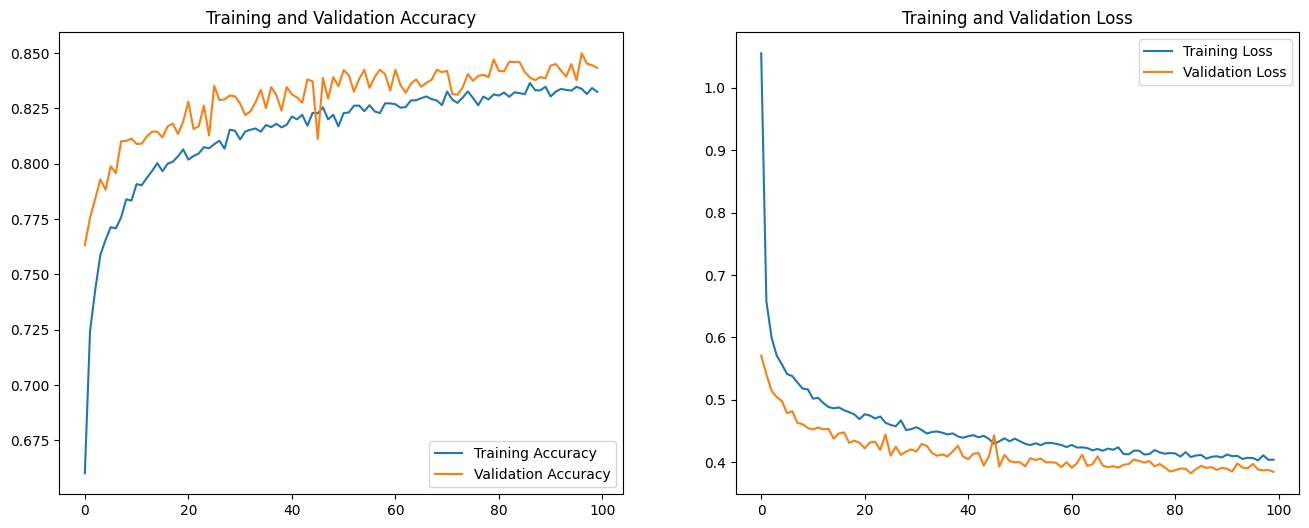

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 43ms/step - loss: 1.0181 - accuracy: 0.6598 - val_loss: 0.6158 - val_accuracy: 0.7477
Epoch 2/100
360/360 [==============================] - 18s 50ms/step - loss: 0.6594 - accuracy: 0.7232 - val_loss: 0.5520 - val_accuracy: 0.7706
Epoch 3/100
360/360 [==============================] - 16s 45ms/step - loss: 0.6104 - accuracy: 0.7417 - val_loss: 0.5349 - val_accuracy: 0.7739
Epoch 4/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5914 - accuracy: 0.7502 - val_loss: 0.5262 - val_accuracy: 0.7721
Epoch 5/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5738 - accuracy: 0.7575 - val_loss: 0.5143 - val_accuracy: 0.7827
Epoch 6/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5592 - accuracy: 0.7647 - v

360/360 [==============================] - 15s 42ms/step - loss: 0.4430 - accuracy: 0.8171 - val_loss: 0.4195 - val_accuracy: 0.8321
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4415 - accuracy: 0.8192 - val_loss: 0.4133 - val_accuracy: 0.8308
Epoch 58/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4438 - accuracy: 0.8178 - val_loss: 0.4088 - val_accuracy: 0.8334
Epoch 59/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4409 - accuracy: 0.8168 - val_loss: 0.4204 - val_accuracy: 0.8268
Epoch 60/100
360/360 [==============================] - 15s 42ms/step - loss: 0.4382 - accuracy: 0.8208 - val_loss: 0.4179 - val_accuracy: 0.8262
Epoch 61/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4392 - accuracy: 0.8191 - val_loss: 0.4079 - val_accuracy: 0.8319
Epoch 62/100
360/360 [==============================] - 16s 43ms/step - loss: 0.4382 - accuracy: 0.8219 - val_loss: 0.4107 - val_accuracy

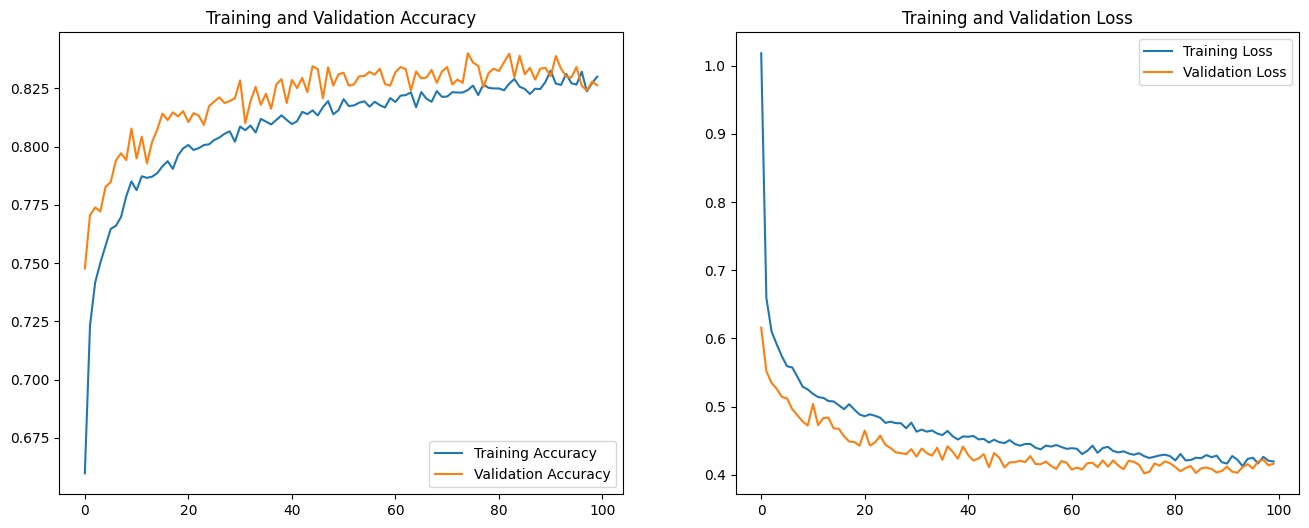

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 18s 44ms/step - loss: 1.0056 - accuracy: 0.6590 - val_loss: 0.5810 - val_accuracy: 0.7555
Epoch 2/100
360/360 [==============================] - 17s 48ms/step - loss: 0.6367 - accuracy: 0.7339 - val_loss: 0.5223 - val_accuracy: 0.7855
Epoch 3/100
360/360 [==============================] - 15s 43ms/step - loss: 0.5845 - accuracy: 0.7549 - val_loss: 0.4978 - val_accuracy: 0.7930
Epoch 4/100
360/360 [==============================] - 15s 42ms/step - loss: 0.5604 - accuracy: 0.7591 - val_loss: 0.4962 - val_accuracy: 0.7876
Epoch 5/100
360/360 [==============================] - 17s 49ms/step - loss: 0.5541 - accuracy: 0.7691 - val_loss: 0.4950 - val_accuracy: 0.7942
Epoch 6/100
360/360 [==============================] - 16s 43ms/step - loss: 0.5415 - accuracy: 0.7733 - val_loss: 0.4742 - va

360/360 [==============================] - 16s 43ms/step - loss: 0.4302 - accuracy: 0.8270 - val_loss: 0.4266 - val_accuracy: 0.8249
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4278 - accuracy: 0.8259 - val_loss: 0.4014 - val_accuracy: 0.8357
Epoch 58/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4247 - accuracy: 0.8277 - val_loss: 0.3990 - val_accuracy: 0.8367
Epoch 59/100
360/360 [==============================] - 15s 43ms/step - loss: 0.4309 - accuracy: 0.8231 - val_loss: 0.3979 - val_accuracy: 0.8411
Epoch 60/100
360/360 [==============================] - 16s 43ms/step - loss: 0.4264 - accuracy: 0.8288 - val_loss: 0.4059 - val_accuracy: 0.8341
Epoch 61/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4253 - accuracy: 0.8273 - val_loss: 0.4036 - val_accuracy: 0.8333
Epoch 62/100
360/360 [==============================] - 16s 44ms/step - loss: 0.4223 - accuracy: 0.8257 - val_loss: 0.4049 - val_accuracy

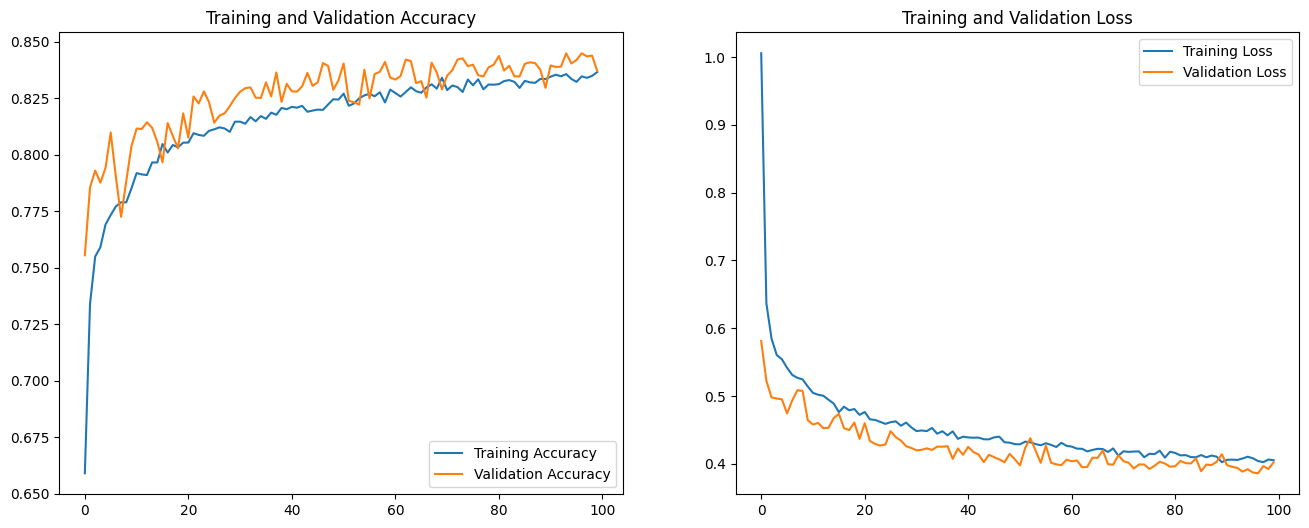

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("vgg19_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("vgg19_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("vgg19_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("vgg19_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("vgg19_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("vgg19_nontrainable/res_ycrcb_nonpre.csv", index=False)